In [2]:
import nltk
nltk.download("punkt") #downloads tokenizer onto computer
nltk.download("stopwords") #downloads onto computer

[nltk_data] Downloading package punkt to /Users/Ben/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/Ben/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
import codecs


import glob - used to search for files on computer. 
    glob.glob returns list of pathnames, with that have pathname specified in param. (Uses unix pathnames)
    ex: *.txt
    
import codecs - used to change word encoding. (utf-8, ascii, utf-16)
    with codecs.open(filename, "r", "utf-8") as filepointer
        pointer.read()

In [4]:
tokenizer = nltk.data.load("tokenizers/punkt/english.pickle")

with codecs.open("got1.txt", "r", "utf-8") as fp:
    corpus = fp.read()

In [5]:
#COPIED:
import glob
book_filenames = sorted(glob.glob("Julius Ceasar.txt"))

print("Found books:", book_filenames)

corpus = u""
for book_filename in book_filenames:
    print("Reading '{0}'...".format(book_filename))
    with codecs.open(book_filename, "r", "utf-8") as book_file:
        corpus += book_file.read()
    print("Corpus is now {0} characters long".format(len(corpus)))
    print()

Found books: ['Julius Ceasar.txt']
Reading 'Julius Ceasar.txt'...
Corpus is now 12992 characters long



In [6]:
raw_sentences = tokenizer.tokenize(corpus)

In [7]:
print(len(raw_sentences))

201


In [8]:
raw_sentences[99]

'Flourish.'

In [9]:
import re
#set = []
#range = [a-z] or [a-zA-Z]
#complement of a set = ^

def split_sentence(sentence):
    clean = re.sub("[^a-zA-Z]", " ", sentence)
    return clean.split()

In [10]:
sentences = [split_sentence(sentence) for sentence in raw_sentences if len(sentence) > 0]

In [12]:
sentences[6]

['Enter', 'Flavius', 'Marullus', 'and', 'certain', 'Commoners']

In [13]:
print("there are ", sum([len(sentence) for sentence in sentences]), " tokens")

there are  2103  tokens


# Train Word2Vec

In [66]:
import multiprocessing
import gensim.models.word2vec as w2v

num_features = 300 #dimension of vector
min_word_count = 3 #min word instance threashold
num_workers = multiprocessing.cpu_count()
context_size = 7 #context window length
downsampling = 1e-3 #downsample setting for frequent words

seed = 1
#seed for the RNG to make the results reproducable ???

In [67]:
thrones2vec = w2v.Word2Vec(
    sg=1,
    seed=seed,
    workers=num_workers,
    size=num_features,
    min_count=min_word_count,
    window=context_size,
    sample=downsampling

)

In [68]:
thrones2vec.build_vocab(sentences)

In [69]:
print(len(thrones2vec.wv.vocab),thrones2vec.corpus_count,thrones2vec.epochs)

165 201 5


In [70]:
thrones2vec.train(sentences,total_words=thrones2vec.corpus_count,epochs=thrones2vec.epochs)

(238, 10515)

In [71]:
import os #interface for os -> abstraction from unix / windows
if not os.path.exists("trained"):
    os.makedirs("trained")
thrones2vec.save(os.path.join("trained", "thrones2vec.w2v"))

In [72]:
thrones2vec.wv.most_similar("Caesar")

[('but', 0.14987826347351074),
 ('a', 0.14219626784324646),
 ('Exeunt', 0.13541960716247559),
 ('SCENE', 0.1298830360174179),
 ('thy', 0.12418904155492783),
 ('this', 0.1228419840335846),
 ('by', 0.1207413375377655),
 ('yourself', 0.11698587983846664),
 ('say', 0.10176163911819458),
 ('more', 0.09061304479837418)]

In [73]:
import sklearn.manifold
tsne = sklearn.manifold.TSNE(n_components=2, random_state=0)

In [74]:
all_word_vectors_matrix = thrones2vec.wv.vectors

In [75]:
all_words_vectors_matrix_2d = tsne.fit_transform(all_word_vectors_matrix)

In [76]:
print(all_words_vectors_matrix_2d.shape, "\n\n",
      len(thrones2vec.wv.vocab))

(165, 2) 

 165


In [77]:
import pandas as pd

points = pd.DataFrame(
    [
        (word,coords[0],coords[1])
        for word, coords in [
            (word, all_words_vectors_matrix_2d[thrones2vec.wv.vocab[word].index])
            for word in thrones2vec.wv.vocab
        ]
        
    ], columns = ["word", "x", "y"])

In [78]:
points.head(10)

,word,x,y
0,OF,0.166561,2.477335
1,CAESAR,-1.932469,-2.040070
2,by,-1.008729,2.302233
3,and,0.342801,-1.904048
4,general,-1.941874,-3.317438
5,after,0.359710,2.284601
6,Caesar,2.582042,-3.808197
7,s,3.602477,3.535949
8,death,-1.307711,-4.045808
9,of,5.573047,-0.208232


In [79]:
import seaborn as sns #data visualization tool
sns.set_context("poster")

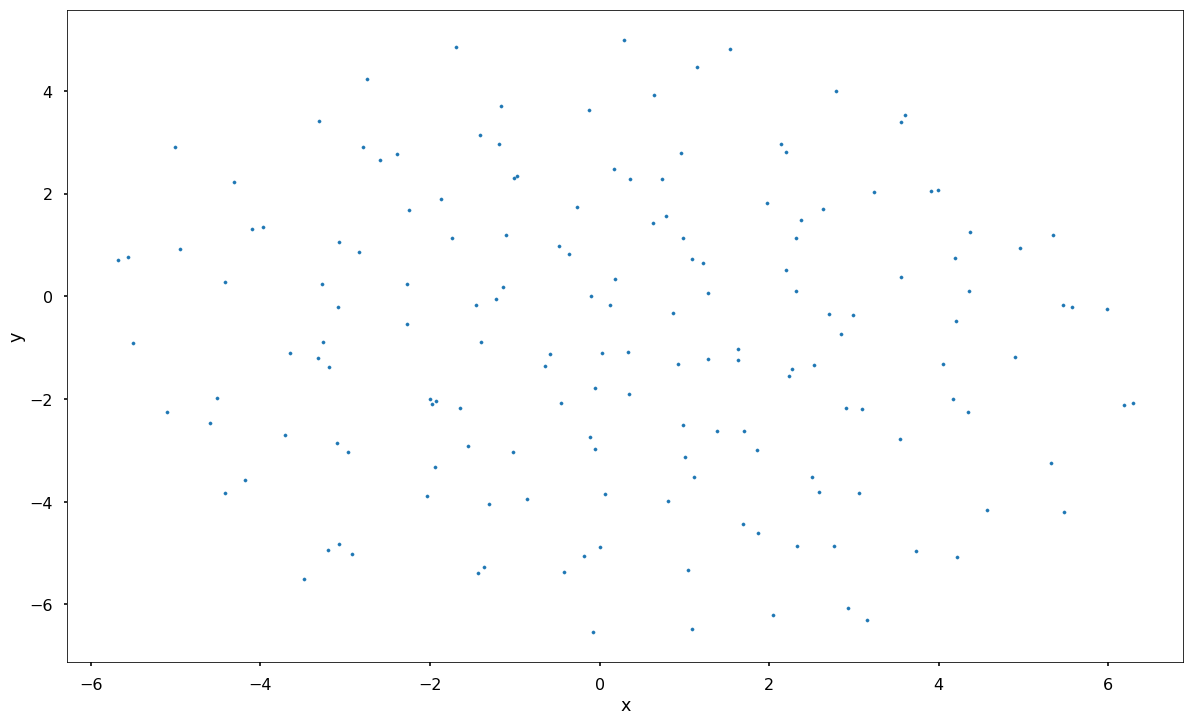

In [80]:
points.plot.scatter("x","y",s=10, figsize=(20,12))

In [81]:
def plot_region(x_bounds,y_bounds):
    section = points[
        (x_bounds[0] <= points.x) &
        (points.x <= x_bounds[1]) & 
        (y_bounds[0] <= points.y) &
        (points.y <= y_bounds[1])
    ]
    
    ax = section.plot.scatter("x","y", s=35, figsize=(10,8))
    
    for i, point in section.iterrows():
        ax.text(point.x + .005, point.y + .005, point.word, fontsize=11)

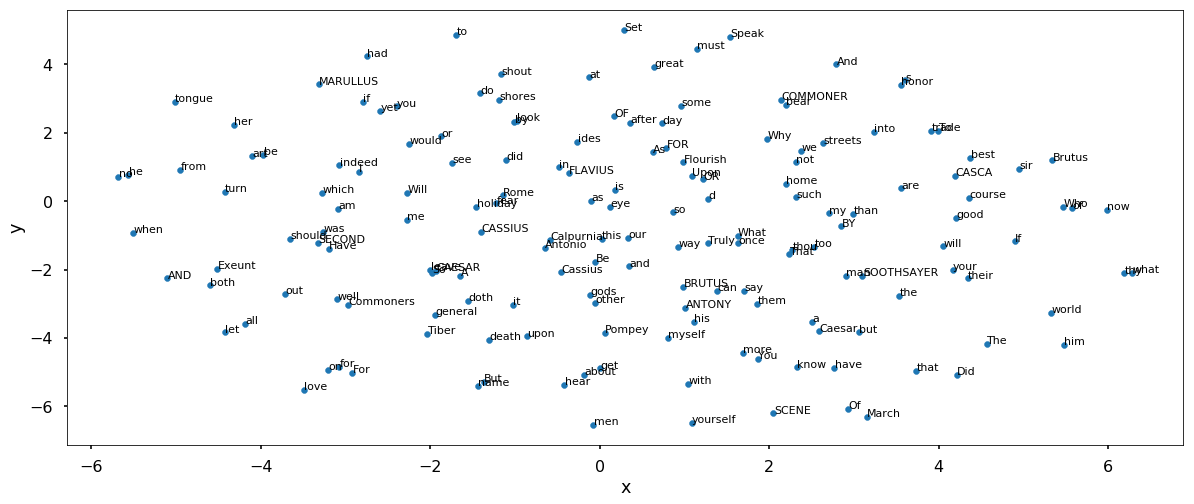

In [82]:
ax = points.plot.scatter("x","y", s=35, figsize=(20,8))
    
for i, point in points.iterrows():
    ax.text(point.x + .005, point.y + .005, point.word, fontsize=11)

In [61]:
plot_region(x_bounds=(0, 5), y_bounds=(0, 5))


ValueError: scatter requires x column to be numeric